In [ ]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [ ]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

In [ ]:
# walk-forward validation
history = [x for x in train]
predictions = list()
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [ ]:

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

In [ ]:
# transform scale
from sklearn.preprocessing import MinMaxScaler
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)


In [ ]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



Using TensorFlow backend.


In [2]:
# load dataset
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
print(raw_values,diff_values)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print(supervised_values)
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
print('train:',train,'test',test)
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print('scaler',scaler)
print('train_scaled',train_scaled)
print('test_scaled',test_scaled)


[ 266.   145.9  183.1  119.3  180.3  168.5  231.8  224.5  192.8  122.9
  336.5  185.9  194.3  149.5  210.1  273.3  191.4  287.   226.   303.6
  289.9  421.6  264.5  342.3  339.7  440.4  315.9  439.3  401.3  437.4
  575.5  407.6  682.   475.3  581.3  646.9] 0    -120.1
1      37.2
2     -63.8
3      61.0
4     -11.8
5      63.3
6      -7.3
7     -31.7
8     -69.9
9     213.6
10   -150.6
11      8.4
12    -44.8
13     60.6
14     63.2
15    -81.9
16     95.6
17    -61.0
18     77.6
19    -13.7
20    131.7
21   -157.1
22     77.8
23     -2.6
24    100.7
25   -124.5
26    123.4
27    -38.0
28     36.1
29    138.1
30   -167.9
31    274.4
32   -206.7
33    106.0
34     65.6
dtype: float64
[[   0.  -120.1]
 [-120.1   37.2]
 [  37.2  -63.8]
 [ -63.8   61. ]
 [  61.   -11.8]
 [ -11.8   63.3]
 [  63.3   -7.3]
 [  -7.3  -31.7]
 [ -31.7  -69.9]
 [ -69.9  213.6]
 [ 213.6 -150.6]
 [-150.6    8.4]
 [   8.4  -44.8]
 [ -44.8   60.6]
 [  60.6   63.2]
 [  63.2  -81.9]
 [ -81.9   95.6]
 [  95.6  -61. ]
 [

In [ ]:
#! python "import keras; print (keras.__version__)"

Month=1, Predicted=304.828014, Expected=339.700000
Month=2, Predicted=375.229349, Expected=440.400000
Month=3, Predicted=363.798069, Expected=315.900000
Month=4, Predicted=392.455624, Expected=439.300000
Month=5, Predicted=350.831005, Expected=401.300000
Month=6, Predicted=460.877647, Expected=437.400000
Month=7, Predicted=401.313873, Expected=575.500000
Month=8, Predicted=436.110778, Expected=407.600000
Month=9, Predicted=487.986565, Expected=682.000000
Month=10, Predicted=503.928575, Expected=475.300000
Month=11, Predicted=529.615849, Expected=581.300000
Month=12, Predicted=473.906613, Expected=646.900000
Test RMSE: 98.006


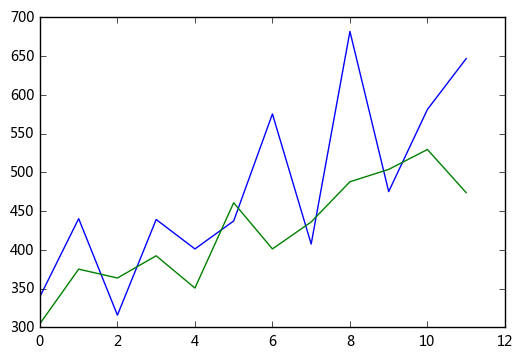

In [3]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()